In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm
from sklearn.cluster import KMeans
from datasets import load_dataset

In [2]:
num_clusters = 18

# Extracting LAB Values

In [3]:
def extract_lab_features(image):
    image = np.array(image)
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [4]:
images = []
l_values = []
a_values = []
b_values = []

In [5]:
dataset = load_dataset("e1010101/tongue-images-all-segmented")

In [6]:
for image_file in tqdm(dataset['train']['image'], desc="Parsing images"):
    l_mean, a_mean, b_mean = extract_lab_features(image_file)
    
    images.append(image_file)
    l_values.append(l_mean)
    a_values.append(a_mean)
    b_values.append(b_mean)

Parsing images: 100%|██████████| 894/894 [00:01<00:00, 470.98it/s]


In [7]:
df = pd.DataFrame({
    'image': images,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

# K-Means Clustering

In [8]:
X = df[['L', 'A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df)

                                                 image           L  \
0    <PIL.PngImagePlugin.PngImageFile image mode=RG...  125.062676   
1    <PIL.PngImagePlugin.PngImageFile image mode=RG...  145.808517   
2    <PIL.PngImagePlugin.PngImageFile image mode=RG...  172.701710   
3    <PIL.PngImagePlugin.PngImageFile image mode=RG...  145.850118   
4    <PIL.PngImagePlugin.PngImageFile image mode=RG...  146.673026   
..                                                 ...         ...   
889  <PIL.PngImagePlugin.PngImageFile image mode=RG...  125.323712   
890  <PIL.PngImagePlugin.PngImageFile image mode=RG...  184.551033   
891  <PIL.PngImagePlugin.PngImageFile image mode=RG...   98.164493   
892  <PIL.PngImagePlugin.PngImageFile image mode=RG...  112.404002   
893  <PIL.PngImagePlugin.PngImageFile image mode=RG...  104.336643   

              A           B  cluster  
0    156.066172  148.274021        9  
1    142.330628  134.056600       11  
2    139.308952  127.962561       15  
3  

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


# Visualizations

In [9]:
unique_clusters = sorted(df['cluster'].unique())

cluster_mapping = {label: idx for idx, label in enumerate(unique_clusters)}

df['cluster_mapped'] = df['cluster'].map(cluster_mapping)

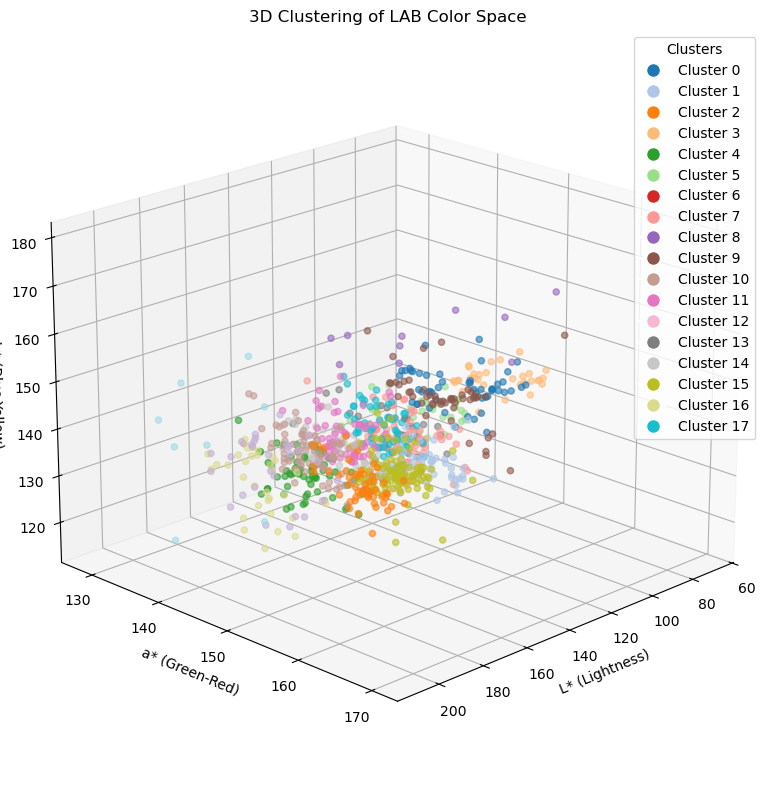

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    l_values, a_values, b_values, 
    c=df['cluster_mapped'], 
    cmap='tab20', 
    alpha=0.6
)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}',
           markerfacecolor=plt.cm.tab20(cluster_mapping[label] / num_clusters), markersize=10)
    for label in unique_clusters
]
ax.legend(handles=legend_elements, title="Clusters", loc='upper right')

# The rest of your plotting code remains the same
ax.set_xlabel('L* (Lightness)')
ax.set_ylabel('a* (Green-Red)')
ax.set_zlabel('b* (Blue-Yellow)')
ax.set_title('3D Clustering of LAB Color Space')
ax.grid(True)
ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

# Image Saving

In [11]:
# Save images to cluster directories
def copy_images_to_clusters(df, base_output_dir):
    import shutil
    import os

    print(f"Base output directory: {base_output_dir}")
    os.makedirs(base_output_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copying images"):
        source_path = row['filename']
        cluster = row['cluster']
        
        cluster_dir = os.path.join(base_output_dir, f"cluster_{cluster}")
        os.makedirs(cluster_dir, exist_ok=True)
        
        filename = os.path.basename(source_path)
        dest_path = os.path.join(cluster_dir, filename)
        
        try:
            shutil.copy2(source_path, dest_path)
        except Exception as e:
            print(f"Error copying file: {e}")

In [12]:
base_output_dir = f"../clusters/{num_clusters}-clusters"
copy_images_to_clusters(df, base_output_dir)

Base output directory: ../clusters/18-clusters


Copying images: 100%|██████████| 894/894 [00:01<00:00, 727.38it/s]
